Linear Regression
=====

Linear Regression attempts to predict a continuous outcome feature (**Y**) from one or more explanatory features (**X**).  

$$Y = \beta_0 + \beta_1 X$$

$\beta_0$ is called the intercept term, and represents the expected mean value of Y when all explanatory features equal 0.  
$\beta_1$ is called a beta coefficient, and represents the expected change in the value of Y that results from a one unit change in X.  

Below is an example of a linear regression with only one explanatory feature. The red dots indicate the actual data, and the blue line represents the predicted **Y** values based on the provided **X** values.  $\beta_0$ appears to equals 0, and $\beta_1$ appears to equal 2.
<img src="./images/LinearRegression.png" alt="Go Find Missing Image" style="width: 500px;height=500"/>

In this lab, we will attempt to construct a linear regression in order to answer a question that Kiva borrowers may have: 

**What impacts the loan amount requested? **

To ensure that our linear regressor is appropriate and interpretable, we will have to confirm the following assumptions are not violated:

1. Linear relationship between x and y
2. Normality
3. Minimal multicollinearity (if multiple variables)
4. No autocorrelation 
5. Homoscedasticity 
- Additional rule of thumb: at least 20 observations per independent variable in the analysis
  
If these assumptions are violated, then the predictive power of the linear regression is still valid but the information concerning the most important features is not. It is important to keep this in mind!


Here's a look ahead at what we'll be doing in these series of notebooks: 

3.1 Load Data and Build Univariate Linear Regression        
3.2 Check Assumptions  
3.3 Build Multivariate Linear Regression 
3.4 Model Evaluation

1. Import packages
-----

In [2]:
import numpy as np
import pandas as pd

# Packages for checking assumptions
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import scatter_matrix
import seaborn as sns
plt.rcParams['figure.figsize'] = (12, 8)
sns.set()
sns.set(font_scale=1.5)

# Packages for checking assumptions
from scipy import stats as stats
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
import statsmodels.formula.api as sm

# Set jupyter notebook preferences
# the command below means that the output of multiple commands in a cell will be output at once.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# the command below tells jupyter to display up to 100 columns, this keeps everything visible
pd.set_option('display.max_columns', 100)
pd.set_option('expand_frame_repr', True)

In [3]:
# Load data
path = '../data/'
filename = 'loans.csv'
df = pd.read_csv(path+filename)

Build Univariate Linear Regression
-----

### Train - Test split

Prior to building our model, we first need to split our dataset into a training set and a test set.  We will use our training set to train our regressor, and we will use our test set for model validation.
To achieve this, we will use call sklearn's [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html), and set the input parameter `test_size` to .2 so that 20% of the data will be assigned to the test set and 80% of the data will be assigned to the training set.

**We set the test set aside and only look at this at the end to evaluate the models performance on unseen data.**

We fix the random state so that each time we run the train_test_split code, we get the same distribution of data. This is important as keeping the data split constant allows us to compare results from different sessions. 

In [6]:
df.columns.tolist()

['id_number',
 'loan_amount',
 'lender_count',
 'status',
 'funded_date',
 'funded_amount',
 'repayment_term',
 'location_country_code',
 'sector',
 'description_texts_en',
 'use']

In [14]:
# Define our dependant variable
y_column = 'loan_amount'
y = df[y_column]
# Define  our independant variables
x_columns = ['lender_count']
X = df[x_columns]
# Add an intercept term to the independant variables. This is needed in order to include the constant term from
# linear regression equation.
X['cnst'] = 1
# Split our data into training and test data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/Users/brian/anaconda3/envs/good/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


### Univariate Linear Regression
In order to build our linear regressor, we will use [statsmodels](http://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html) implementation.  The are other implementations out there; however, we will use statmodels because it creates a nice summary table for model evaluation. Let's print out the summary table to demonstrate how easy it is to train the model and see the results.

For an in-depth review on all the statistics and numbers given in the summary below, check out this [awesome page!](http://connor-johnson.com/2014/02/18/linear-regression-with-python/)

In [9]:
model = sm.OLS(endog=y_train, exog=X_train).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            loan_amount   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     2153.
Date:                Mon, 23 Jul 2018   Prob (F-statistic):          1.47e-116
Time:                        18:54:14   Log-Likelihood:                -2011.4
No. Observations:                 225   AIC:                             4027.
Df Residuals:                     223   BIC:                             4034.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
lender_count    30.0242      0.647     46.406   

Model interpretation
-----

This is the typical regression output. It's a lot to digest! 

Remember that our linear regression model can be represented as an equation, like this: 

    loan_amount = intercept + coef*lender_count

What is the intercept value?   

In [12]:
model.params.cnst

1012.0986244228579

What does that intercept value tell us?

<br>
<br>
<br>

What is the coefficent for `lender_count`?

In [13]:
model.params.lender_count

30.024200763020453

What does that coeffiecent value tell us?

<br>
<br>
<br>
-----

How do we know however, whether this is a significant result?

We have a sufficient amount of confidence in this conclusion because the **p-value** is reported to be 0.000. In technical terms, the p-value is **the probability of getting results as extreme as the ones observed given no correlation. **

In statistics, we want our results to fall within the 95% confidence interval, or the p-value to be <= 0.05. This means, "[i]f repeated samples were taken and the 95% confidence interval was computed for each sample, 95% of the intervals would contain the population mean. A 95% confidence interval has a 0.95 probability of containing the population mean. 95% of the population distribution is contained in the confidence interval." [Read more here.](http://www.investopedia.com/terms/s/standard-error.asp) The p-value is an indicator of where we fall in the confidence interval. In English, small p-value (<= 0.05) indicates strong evidence that the coefficient is different than 0. 

This is a relatively simplified explanation of p-values. Don't worry if it's not immediately intuitive - [not even professional statisticians can easily explain this concept.](http://fivethirtyeight.com/features/not-even-scientists-can-easily-explain-p-values/) To get a deeper understanding, we recommend grabbing the nearest textbook on statistics to review! 

Note also that the Adjusted R Squared is extremely low. To recap lessons from Module 2, the Adjusted R Squared is an explanation of how much of the outcome feature can be explained by the model's explanatory features. This low Adj R Squared suggests that the predictive value of borrower_count alone is pretty low - it cannot be used as the single feature to predict loan_amount. 

This result is in line with our understanding of the world - there must be other factors influencing loan_amount!

**Before we start looking for other explanatory features, it is important to note that interpretation of the results above is only valid if the assumptions of linear regression are not violated. Lets go through these assumptions now...**

-----
Linear Regression: Check Assumptions
=====

In order for linear regression to be an appropriate model, the following assumptions must be confirmed:

1. Linear relationship between x and y
1. Normality of residuals
1. Minimal multicollinearity 
1. No autocorrelation
1. Homoscedasticity 

### Linearity
First, as the name implies, linear regression requires the underlying relationship between the independent (x) and dependent (y) variables to be linear. This means that a line drawn through the points can capture the relationship, with some degree of error. 

We must also be aware of outliers, which can throw off a linear relationship. 

The most straightforward check of linearity is to make scatter plots of the variables chosen.

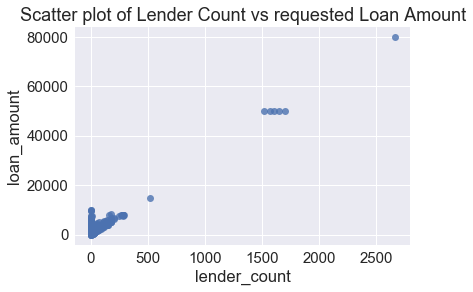

In [21]:
ax = sns.regplot(x=x_columns[0], y=y_column, data=df, fit_reg=False);
ax.set_title(f'Scatter plot of {x_columns[0].replace("_", " ").title()} vs requested {y_column.replace("_", " ").title()}');

What is the general trend?

Are there outliners?

-----
Normality
-----

Normality means the distribution of values falls into a normal distribution. 

The results summary printed above gives us an indication of whether or not our data is normally distributed. If the **Prob(JB)** number is less than 0.05, this means that we can reject the Null hypothesis that the data distribution is normal. If this is the case, we need to look into our model more closely see where this is coming from and how/if we can rectify the issue.

We can visualize the normality of the data by making histograms or Q-Q (quantile-quantile) plots.

First we will look at a histogram for the dependant variable, loan_amount. From this, we can see that the dependant variable is skewed to the left.

/Users/brian/anaconda3/envs/good/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


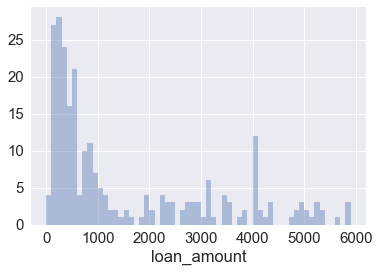

In [23]:
sns.distplot(df[df[y_column]<=6000][y_column], bins=range(0, 6000, 100), kde=False, norm_hist=False);

Furthermore, we can create a quantile-quantile plot to see how the distribution of data compares that expected from a normal distribution. In these plots, the quantiles from the measured data are compared to that of a normal distribution and if the measured data is normal, we expect to see a straight line.

The plot below clearly shows that the dependent variable is not normal and therefore we need to investigate the skew further to see if the data required transformation. 

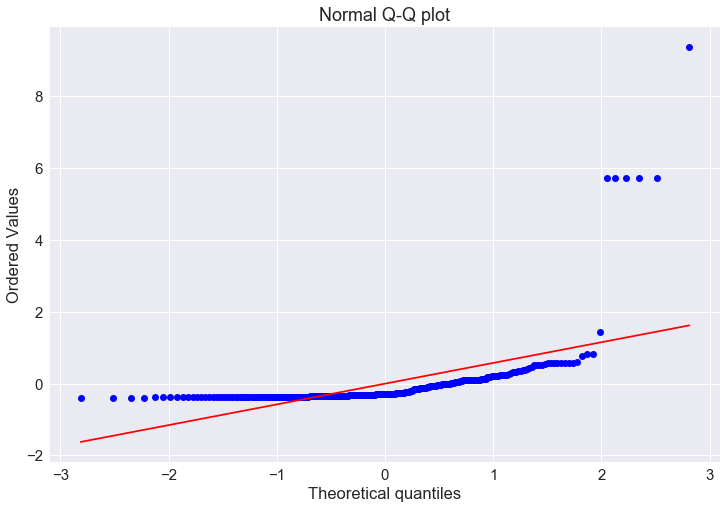

In [24]:
# Convert depedant variable to a numpy and standardise the data
y = np.asarray(df[y_column])
standardised_y = (y-np.mean(y))/np.std(y)
# create a normal Q-Q plot using the stats module probplot
plt.figure(figsize=(12,8))
stats.probplot(standardised_y, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show();

If a variable is not normal, it may be adjusted by a [non-linear transformation](https://stats.stackexchange.com/questions/298/in-linear-regression-when-is-it-appropriate-to-use-the-log-of-an-independent-va).

We already know our data is skewed by outliers, however before we begin modeling let's quantify the degree to which it is skewed.

[Scipy's stats package](https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.stats.skew.html) allows you to conduct a skew test. A normally distributed dataset would return about 0. A skewness value of greater than 0 means there are more loans in the left tail of the distribution. Typically, a skew score of +-5 is deemed acceptable.


[Multivariate normality](https://en.wikipedia.org/wiki/Multivariate_normal_distribution) is a generalization of one-dimensional, or univariate, normality, to more dimensions. For a regression using multiple independent (x) variables, this means checking that all of the linear combinations of variables used are normal. 


In [25]:
print(f"{stats.skew(df[y_column], axis=None):.4}")

6.251


We can continue with the linear regression model for predicting the loan_amount however, we should be aware that our beta-coefficients may be __not__ be reliable do to the skewness of the data. 

__If you face a dataset with more severely skewed data, we describe a way to address this in the appendix below.__

### Multicollinearity

To recap Module 2's lesson, multicollinearity means that two or more explanatory features are highly correlated.

This makes it difficult for the model to try to differentiate between each feature's influence on the explanatory feature.

Again, the summary table from the linear regression can help us again. There is a statistic in the bottom right hand corner known as the **condition number**. This indicates the severity and impact of multicolinearity in the regression and as a rule fo thumb, values over 30 are an issue. 

One way to check this is by examining the correlation matrix and making sure none of the variables correlate to 1. Numpy's Corrcoef function returns a matrix of Pearson correlation coefficients. 

Read more about Numpy's Corrcoef [here](https://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.corrcoef.html).

It would take a long time for us to test each and every relationship between two sets of variables, so let's create a correlation matrix that lets us visualize every correlation in a dataset using Pandas.

In [26]:
df_corr_tbl = df[x_columns]
df_corr_tbl.corr()

,lender_count
lender_count,1.0


In [27]:
for col in df.columns:
    print(col)

id_number
loan_amount
lender_count
status
funded_date
funded_amount
repayment_term
location_country_code
sector
description_texts_en
use


### No autocorrelation

A variable has autocorrelation when values in the series correlate with others in the same series, separated by a given interval.

In terms of the residuals, this means checking that residuals are independent.

A check for this is the **Durbin-Watson test**. The durbin-watson statistic ranges from 0 to 4 with values around 2 suggesting no autocorrelation. Values < 2 suggest positive correlation and values > 2 suggest negative correlation.

In the summary table above, the Durbin-Watson test has a value of 1.998 so we can be happy that there is no autocorrelation.

### Homoscedasticity

Homoscedasticity is a statistical term that means that the spread of the residuals are equal across the regression line. This assumption means that the variance around the regression line is the same for all values of the predictor variable (X). 

Again, the summary table from the linear regression allows us to evaluate whether the model has homoscedasticity. If **Prob(Omnibus)** number is less than 0.05 we can reject the Null Hypothesis that the residuals are distributed uniformly and normally around zero.

In the case above, the Prob(Omnibus) is 0.00 which clearly indicates that the model does not have homoscedasticity.

This can be seen the plot below, the distribution of the residual are not consistent across the range of data. Therefore, we need to work on our regression model more!

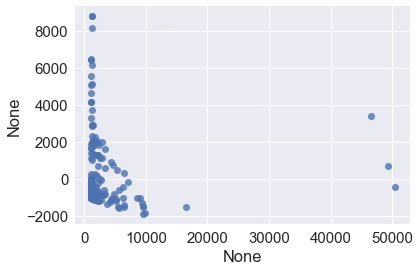

In [28]:
y_pred = model0.predict(X_train)
ax = sns.regplot(x=y_pred, y=(y_train-y_pred), fit_reg=False)

Summary
----

To recap the finding from the linear regression assumptions check above:

1. Linear relationship between x and y
  - For the independent variable 'borrower_count', there is multi-trend linear relationship
1. Normality
  - The dependent variable data is not normally distributed and is left-hand skewed. 
1. Minimal multicollinearity 
  - There is minimal/weak multicollinearity between feature which is not much of a concern.
1. No autocorrelation
  - Durbin-Watson test indicates no autocorrelation
1. Homoscedasticity 
  - With the single independent feature of borrower_count, the model is not homoscedacity. We will build upon our model and try again.


<br>
<br> 
<br>

----